In [27]:
import pandas as pd
import re

# Data inlezen
df_kabinetten = pd.read_csv('kabinetten.csv')

# Functie om Nederlandse datums naar een standaard formaat te converteren

def parse_nl_date(date_str):
    try:
        months = {
            'januari': '01', 'februari': '02', 'maart': '03', 'april': '04',
            'mei': '05', 'juni': '06', 'juli': '07', 'augustus': '08', 'september': '09',
            'oktober': '10', 'november': '11', 'december': '12'
        }

        day, month, year = re.split(r'\s+', date_str.strip())
        month_num = months[month.lower()]
        date_formatted = f'{year}-{month_num}-{day.zfill(2)}'
        return pd.to_datetime(date_formatted, errors='coerce')
    except:
        return pd.NaT

# Converteer datums naar datetime
df_kabinetten['Aantreden'] = df_kabinetten['Aantreden'].apply(parse_nl_date)
df_kabinetten['Verkiezing'] = df_kabinetten['Verkiezing'].apply(parse_nl_date)
df_kabinetten['Aftreden'] = df_kabinetten['Aftreden'].apply(parse_nl_date)


# Filter data vanaf 1918
df_kabinetten = df_kabinetten[df_kabinetten['Aantreden'].dt.year >= 1918]

# Data opschonen
df_kabinetten.to_csv('kabinetten_schoongemaakt.csv', index=False)

print("Data is schoongemaakt en opgeslagen in 'kabinetten_schoongemaakt.csv'.")


Data is schoongemaakt en opgeslagen in 'kabinetten_schoongemaakt.csv'.


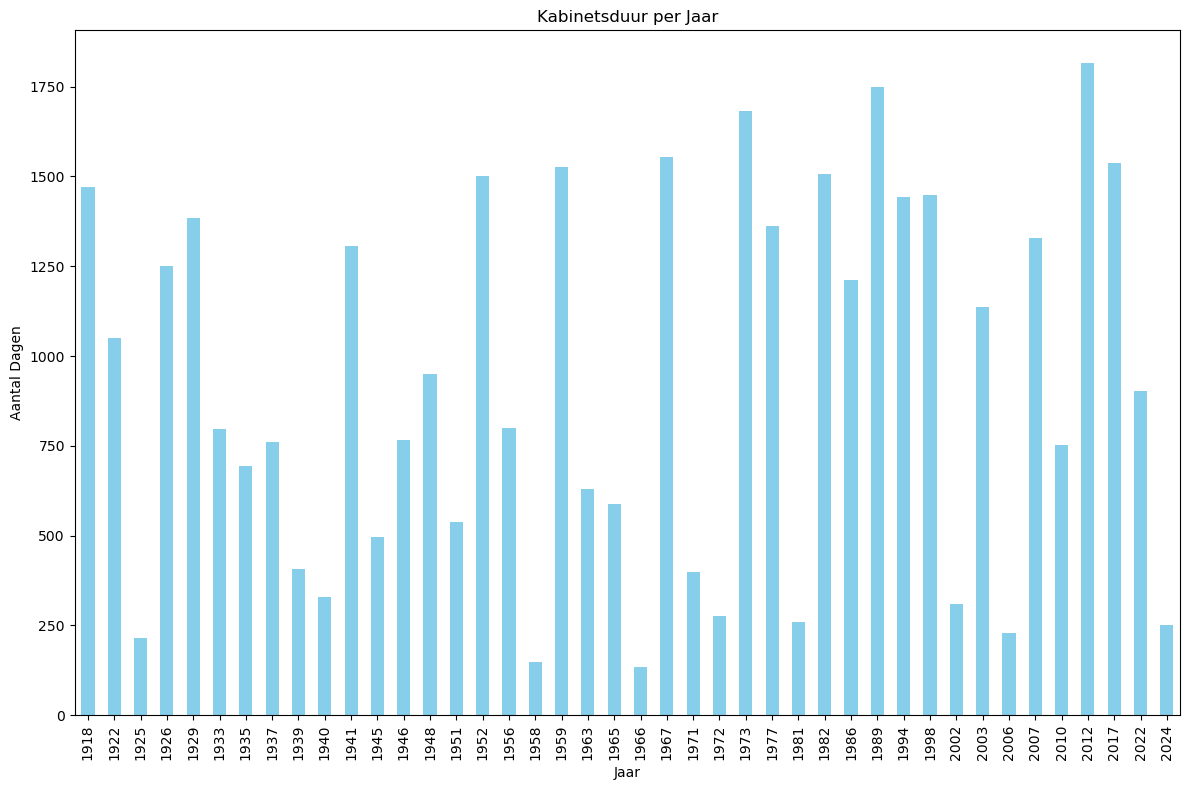

In [28]:
import matplotlib.pyplot as plt

# Data inlezen
df_kabinetten = pd.read_csv('kabinetten_schoongemaakt.csv')

# Kabinetsduur analyseren
df_kabinets_duur = df_kabinetten.groupby(df_kabinetten['Aantreden'].str[:4].astype(int))['Dagen'].sum()

# Trends in kabinetsduur visualiseren
plt.figure(figsize=(12, 8))
df_kabinets_duur.plot(kind='bar', color='skyblue')
plt.ylabel('Aantal Dagen')
plt.xlabel('Jaar')
plt.title('Kabinetsduur per Jaar')
plt.tight_layout()
plt.show()


Accuracy: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.75      0.86      0.80         7

    accuracy                           0.67         9
   macro avg       0.38      0.43      0.40         9
weighted avg       0.58      0.67      0.62         9

Confusion Matrix:


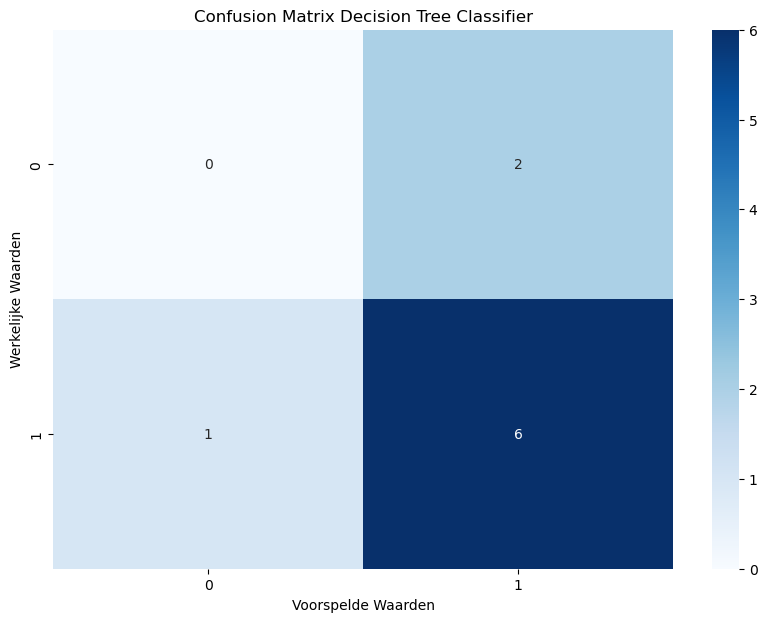

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Data inlezen
df_kabinetten = pd.read_csv('kabinetten_schoongemaakt.csv')

# Zet datetime kolommen om naar tijdsdelta's vanaf een referentiepunt, indien niet gedaan
ref_date = pd.Timestamp('1918-01-01')
df_kabinetten['Verkiezing'] = (pd.to_datetime(df_kabinetten['Verkiezing']) - ref_date).dt.days
df_kabinetten['Aantreden'] = (pd.to_datetime(df_kabinetten['Aantreden']) - ref_date).dt.days

# Selecteer relevante kolommen en one-hot encoding voor 'Partijen'
X = pd.concat([df_kabinetten[['Verkiezing', 'Aantreden']], pd.get_dummies(df_kabinetten['Partijen'])], axis=1)

# Target column (Dagen)
y = df_kabinetten['Dagen']

# Binaire classificatie (voorbeeld: kabinetsduur langer dan 1 jaar)
y_binary = y.apply(lambda x: 1 if x > 365 else 0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=5)  # max_depth kan worden aangepast voor beter resultaat
clf.fit(X_train, y_train)

# Predicties
y_pred = clf.predict(X_test)

# Evaluatie
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion matrix plotten
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Voorspelde Waarden')
plt.ylabel('Werkelijke Waarden')
plt.title('Confusion Matrix Decision Tree Classifier')
plt.show()


/tmp/ipykernel_14969/3497786071.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_kabinetten['Verkiezing'].fillna(default_date, inplace=True)
/tmp/ipykernel_14969/3497786071.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

Class distribution in the target variable:
Dagen
1    33
0    12
Name: count, dtype: int64
Train set size: 36
Test set size: 9
Accuracy: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.75      0.86      0.80         7

    accuracy                           0.67         9
   macro avg       0.38      0.43      0.40         9
weighted avg       0.58      0.67      0.62         9

Confusion Matrix:


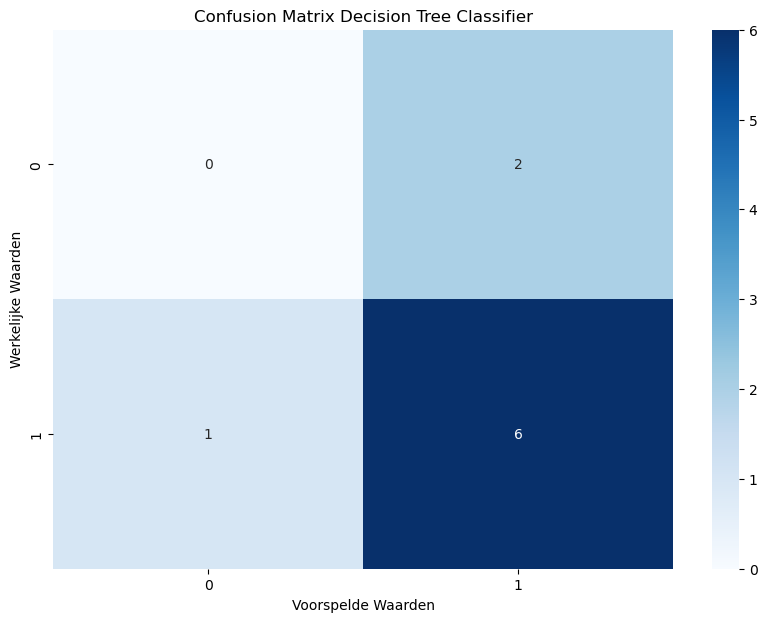

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Data inlezen
df_kabinetten = pd.read_csv('kabinetten_schoongemaakt.csv')

# Zet datetime kolommen om naar time delta's vanaf een referentiepunt '1918-01-01'
ref_date = pd.Timestamp('1918-01-01')
df_kabinetten['Verkiezing'] = pd.to_datetime(df_kabinetten['Verkiezing'], errors='coerce')
df_kabinetten['Aantreden'] = pd.to_datetime(df_kabinetten['Aantreden'], errors='coerce')

# Vul ontbrekende datumwaarden in 'Verkiezing' en 'Aantreden' met een default jaar
default_date = ref_date + pd.DateOffset(years=1)  # Voeg één jaar toe aan ref_date als default
df_kabinetten['Verkiezing'].fillna(default_date, inplace=True)
df_kabinetten['Aantreden'].fillna(default_date, inplace=True)

# Zet datetime kolommen om naar tijdsdelta's vanaf het referentiepunt
df_kabinetten['Verkiezing'] = (df_kabinetten['Verkiezing'] - ref_date).dt.days
df_kabinetten['Aantreden'] = (df_kabinetten['Aantreden'] - ref_date).dt.days

# Verwerk de 'Partijen' kolom zodat multiple parties wordt gesplitst en gecodeerde
def split_and_rename_parties(df):
    df_parties_expanded = df['Partijen'].str.get_dummies(sep=',')
    df_combined = pd.concat([df.drop(['Partijen'], axis=1), df_parties_expanded], axis=1)
    return df_combined

df_kabinetten_expanded = split_and_rename_parties(df_kabinetten)

# Selecteer relevante kolommen
X = df_kabinetten_expanded.drop(['Kabinet', 'Foto', 'Minister-president', 'Demissionair', 'Aftreden', 'Dagen'], axis=1)
y = df_kabinetten_expanded['Dagen']

# Vul ontbrekende waarden in de feature matrix met de mediaan (of andere passende strategie)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Binaire classificatie
y_binary = y.apply(lambda x: 1 if x > 365 else 0)

# Controleer klasseverdeling
print("Class distribution in the target variable:")
print(y_binary.value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Controleer grootte van de training en test sets
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

# SMOTE oversampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train_res, y_train_res)

# Predicties
y_pred = clf.predict(X_test)

# Evaluatie
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion matrix plotten
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Voorspelde Waarden')
plt.ylabel('Werkelijke Waarden')
plt.title('Confusion Matrix Decision Tree Classifier')
plt.show()


In [41]:
import pandas as pd

# Data inlezen
df_kabinetten = pd.read_csv('kabinetten_schoongemaakt.csv')

# Converteer 'Dagen' naar numerieke waarden indien nodig
df_kabinetten['Dagen'] = df_kabinetten['Dagen'].apply(pd.to_numeric, errors='coerce')

# Filter kabinetten die minder dan een jaar (365 dagen) duurden
df_short_term = df_kabinetten[df_kabinetten['Dagen'] <= 365]

# Print informatie over kabinetten die minder dan een jaar duurden
print("Kabinetten die minder dan een jaar duurden:")
print("\n")
print(df_short_term[['Kabinet', 'Minister-president', 'Partijen', 'Aantreden', 'Aftreden', 'Dagen']])


Kabinetten die minder dan een jaar duurden:


           Kabinet          Minister-president                   Partijen  \
2         Colijn I      Hendrikus Colijn (ARP)             RKSP, ARP, CHU   
8         Colijn V            Hendrikus Colijn              ARP, CHU, LSP   
10     Gerbrandy I      Pieter Gerbrandy (ARP)  RKSP, SDAP, ARP, CHU, VDB   
12   Gerbrandy III      Pieter Gerbrandy (ARP)             RKSP, ARP, VDB   
19         Beel II            Louis Beel (KVP)              KVP, ARP, CHU   
23        Zijlstra        Jelle Zijlstra (ARP)                   KVP, ARP   
26   Biesheuvel II     Barend Biesheuvel (ARP)         KVP, VVD, ARP, CHU   
29      Van Agt II         Dries van Agt (CDA)            CDA, PvdA, D'66   
30     Van Agt III         Dries van Agt (CDA)                  CDA, D'66   
36    Balkenende I  Jan Peter Balkenende (CDA)              CDA, LPF, VVD   
38  Balkenende III  Jan Peter Balkenende (CDA)                   CDA, VVD   
44          Schoof    Dick Sch

/tmp/ipykernel_14969/4105176339.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_kabinetten['Verkiezing'].fillna(default_date, inplace=True)
/tmp/ipykernel_14969/4105176339.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

Kolom types in de DataFrame:
Kabinet                       object
Foto                         float64
Minister-president            object
Partijen                      object
Zetelverdeling               float64
Verkiezing            datetime64[ns]
Aantreden             datetime64[ns]
Demissionair                  object
Aftreden                      object
Dagen                          int64
Verkiezingsjaar                int32
Aantredingsjaar                int32
Meerderheid                    int64
dtype: object
Accuracy: 0.5555555555555556
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.71      0.71      0.71         7

    accuracy                           0.56         9
   macro avg       0.36      0.36      0.36         9
weighted avg       0.56      0.56      0.56         9

Confusion Matrix:


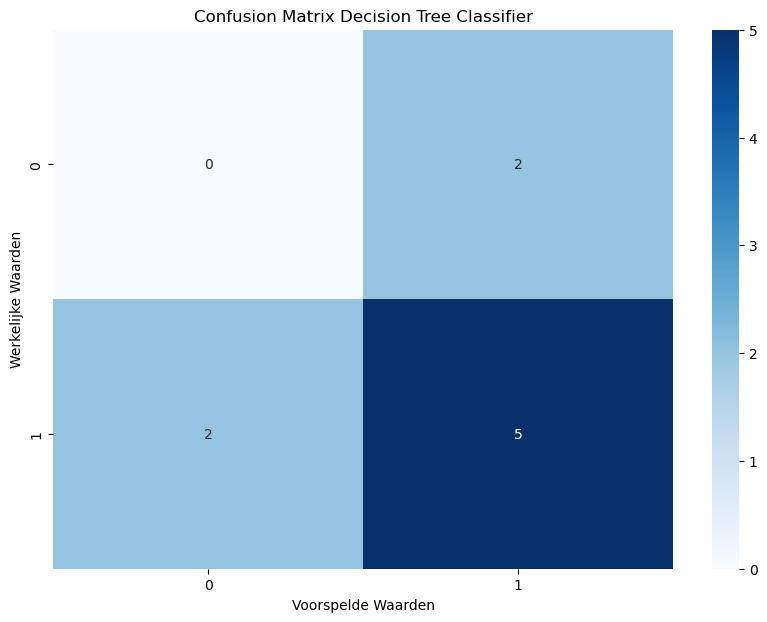

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Data inlezen voor kabinetten
df_kabinetten = pd.read_csv('kabinetten_schoongemaakt.csv')

# Zet datum kolommen om naar datetime objecten
df_kabinetten['Verkiezing'] = pd.to_datetime(df_kabinetten['Verkiezing'], errors='coerce')
df_kabinetten['Aantreden'] = pd.to_datetime(df_kabinetten['Aantreden'], errors='coerce')

# Vul ontbrekende datumwaarden in 'Verkiezing' en 'Aantreden' met een default jaar
default_date = pd.Timestamp('1919-01-01')
df_kabinetten['Verkiezing'].fillna(default_date, inplace=True)
df_kabinetten['Aantreden'].fillna(default_date, inplace=True)

# Zet datum kolommen om naar jaren
df_kabinetten['Verkiezingsjaar'] = df_kabinetten['Verkiezing'].dt.year
df_kabinetten['Aantredingsjaar'] = df_kabinetten['Aantreden'].dt.year

# Data inlezen voor zetelverdeling
df_zetels_100 = pd.read_csv('../zetelverdeling/zetel-data/tk_zetels100_1918-1956.csv')
df_zetels_150 = pd.read_csv('../zetelverdeling/zetel-data/tk_zetels150_1956-2023.csv')

# Combineer beide zetelverdeling datasets
df_zetels = pd.concat([df_zetels_100, df_zetels_150], ignore_index=True)

# Zet zetelverdeling data om naar een pivot tabel met jaren als index
df_zetels_pivot = df_zetels.pivot_table(index='Jaar', columns='Partij', values='Zetels', aggfunc='sum').fillna(0)

# Bepaal meerderheidszetels voor kabinetten, met error handling voor ontbrekende jaren
def check_majority(df_kabinet, df_zetelspivot):
    majority_list = []
    for index, row in df_kabinet.iterrows():
        election_year = row['Verkiezingsjaar']
        cabinet_parties = row['Partijen'].split(',')
        party_seats = 0
        if election_year in df_zetelspivot.index:
            party_seats = df_zetelspivot.loc[election_year, cabinet_parties].sum()
            if election_year <= 1956:
                if party_seats > 50:  # Majority seats pre-1956
                    majority_list.append(1)
                else:
                    majority_list.append(0)
            else:
                if party_seats > 75:  # Majority seats post-1956
                    majority_list.append(1)
                else:
                    majority_list.append(0)
        else:
            majority_list.append(0)  # Stel geen meerderheid indien jaar ontbreekt
    return majority_list

df_kabinetten['Meerderheid'] = check_majority(df_kabinetten, df_zetels_pivot)

# Inspecteer DataFrame op niet-numerieke kolommen
print("Kolom types in de DataFrame:")
print(df_kabinetten.dtypes)

# Verwerking en one-hot encoding van 'Partijen' kolom
def split_and_rename_parties(df):
    df_parties_expanded = df['Partijen'].str.get_dummies(sep=',')
    df_combined = pd.concat([df.drop(['Partijen'], axis=1), df_parties_expanded], axis=1)
    return df_combined

df_kabinetten_expanded = split_and_rename_parties(df_kabinetten)

# Maak Feature Matrix en Target Variable
X = df_kabinetten_expanded.drop(['Kabinet', 'Foto', 'Minister-president', 'Demissionair', 'Aftreden', 'Dagen'], axis=1)
y = df_kabinetten_expanded['Dagen']

# Zorg dat alle kolommen numeriek zijn
X = X.apply(pd.to_numeric, errors='coerce')

# Vul ontbrekende waarden in de feature matrix met de mediaan
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Binaire classificatie voor target variable
y_binary = y.apply(lambda x: 1 if x > 365 else 0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Oversampling met SMOTE om data balans te verbeteren
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train_res, y_train_res)

# Predicties maken
y_pred = clf.predict(X_test)

# Evaluatie
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion matrix plotten
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Voorspelde Waarden')
plt.ylabel('Werkelijke Waarden')
plt.title('Confusion Matrix Decision Tree Classifier')
plt.show()
